<a href="https://colab.research.google.com/github/AlvaroUriel/idal_ia3/blob/main/TareaNLP_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [3]:
df_train = pd.read_csv('sem_eval_train_es.csv')
df_train.head()


,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-Es-01643,@aliciaenp Ajajjaa somos del clan twitteras pe...,False,False,False,False,True,False,False,False,False,False,False
1,2018-Es-05142,@AwadaNai la mala suerte del gato fichame la c...,False,False,False,True,False,False,False,True,False,False,False
2,2018-Es-05379,@audiomano A mí tampoco me agrado mucho eso. E...,True,False,False,False,False,False,False,False,False,False,False
3,2018-Es-00208,Para llevar a los bebes de un lugar a otro deb...,False,False,False,False,True,False,False,False,False,False,False
4,2018-Es-01385,@DalasReview me encanta la terrible hipocresia...,True,False,True,False,False,False,False,False,False,False,False


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3561 entries, 0 to 3560
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            3561 non-null   object
 1   Tweet         3561 non-null   object
 2   anger         3561 non-null   bool  
 3   anticipation  3561 non-null   bool  
 4   disgust       3561 non-null   bool  
 5   fear          3561 non-null   bool  
 6   joy           3561 non-null   bool  
 7   love          3561 non-null   bool  
 8   optimism      3561 non-null   bool  
 9   pessimism     3561 non-null   bool  
 10  sadness       3561 non-null   bool  
 11  surprise      3561 non-null   bool  
 12  trust         3561 non-null   bool  
dtypes: bool(11), object(2)
memory usage: 94.0+ KB


In [5]:
df_train.count()

ID              3561
Tweet           3561
anger           3561
anticipation    3561
disgust         3561
fear            3561
joy             3561
love            3561
optimism        3561
pessimism       3561
sadness         3561
surprise        3561
trust           3561
dtype: int64

Vemos un ejemplo de Tweet

In [6]:
df_train.iloc[16].Tweet

'Que bien se siente pelear de nuevo, aunque esté bien tronco '

Vemos como es la distribución de etiquetas


In [7]:
print(df_train.anger.value_counts()[1])
print(df_train.anticipation.value_counts()[1])
print(df_train.disgust.value_counts()[1])
print(df_train.fear.value_counts()[1])
print(df_train.joy.value_counts()[1])
print(df_train.optimism.value_counts()[1])
print(df_train.pessimism.value_counts()[1])
print(df_train.sadness.value_counts()[1])
print(df_train.surprise.value_counts()[1])
print(df_train.trust.value_counts()[1])

1155
415
521
373
1087
378
578
845
169
175


Vemos la longitud de los Tweets antes de la limpieza

In [8]:
df_train['pre_clean_len'] = df_train.Tweet.str.len()
df_train.pre_clean_len.describe()

count    3561.000000
mean       77.048301
std        35.753085
min         9.000000
25%        47.000000
50%        73.000000
75%       106.000000
max       140.000000
Name: pre_clean_len, dtype: float64

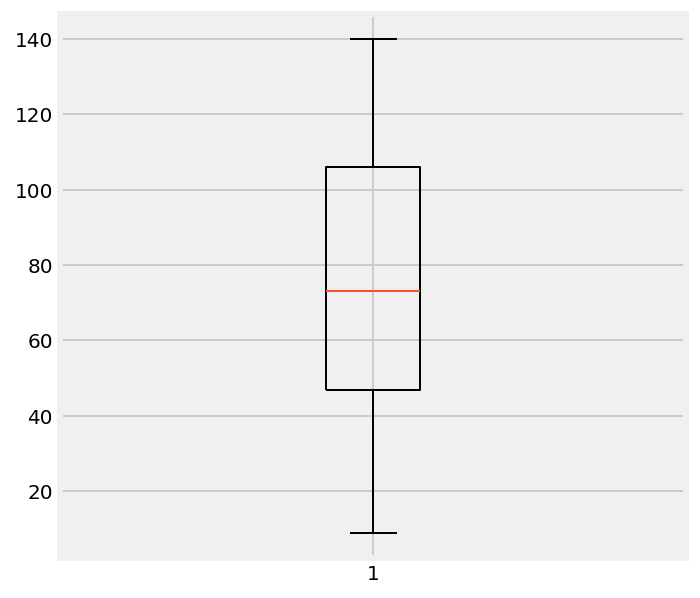

In [9]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df_train.pre_clean_len)
plt.show()

## Limpieza de texto
Hacemos un pequeño pre-procesado del texto antes de extraer las características:  
- Quitamos las menciones y las URL del texto porque no aportan valor para el análisis de sentimientos.
- Los hashtag sí que pueden aportar valor así que simplemente quitamos el #.
- Quitamos los signos de puntuación y palabras menores de 3 caracteres.
- Por último quitamos todos los símbolos de puntuación del texto (que forman parte de un token).
- Lematizamos el texto y lo guardamos en otra columna para comparar resultados del clasificador.

In [10]:
!pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
!python -m spacy download es_core_news_md

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42.3 MB 1.7 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')


In [12]:
import re, string, spacy
nlp=spacy.load('es_core_news_md')

In [13]:
#lista de stop-words específicos de nuestro corpus (aproximación)
stop_words = ['unos', 'unas', 'algún', 'alguna', 'algunos', 'algunas', 'ese', 'eso', 'así']

pattern2 = re.compile('[{}]'.format(re.escape(string.punctuation))) #elimina símbolos de puntuación

def clean_text(text, lemas=False):
    """Limpiamos las menciones y URL del texto. Luego convertimos en tokens
    y eliminamos signos de puntuación.
    Si lemas=True extraemos el lema, si no dejamos en minúsculas solamente.
    Como salida volvemos a convertir los tokens en cadena de texto"""
    text = re.sub(r'@[\w_]+', 'MENCION', text) #elimina menciones y URL
    #text = re.sub(r'|https?://[\w_./]+', 'URL', text) #elimina menciones y URL
    text = re.sub(r'\S*https?:\S*', "URL", text)

    tokens = nlp(text)
    tokens = [tok.lemma_.lower() if lemas else tok.lower_ for tok in tokens if not tok.is_punct]
    filtered_tokens = [pattern2.sub('', tok) for tok in tokens if not (tok in stop_words) and len(tok)>2]
    filtered_text = ' '.join(filtered_tokens)
    
    return filtered_text
    

In [14]:
print('Original:\n',df_train.Tweet[16])
print('\nLimpiado:\n',clean_text(df_train.Tweet[16]))
print('\nLematizado:\n',clean_text(df_train.Tweet[16], lemas=True))

Original:
 Que bien se siente pelear de nuevo, aunque esté bien tronco 

Limpiado:
 que bien siente pelear nuevo aunque esté bien tronco

Lematizado:
 que bien sentir pelear nuevo aunque estar bien tronco


In [15]:
df_train[df_train.Tweet.str.contains('http')]


,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,pre_clean_len
1058,2018-Es-04461,¡Gran susto en la casa de #MOParaguay!😱 ¿Ña Su...,False,False,False,True,False,False,False,False,False,False,False,140


In [16]:
df_train["limpio"]=df_train['Tweet'].apply(clean_text)

In [17]:
#Quitamos tweets vacíos después de la limpieza
df_train=df_train[df_train.limpio!='']

In [18]:
df_train['lemas'] = df_train['Tweet'].apply(clean_text, lemas=True)

In [19]:
df_train.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,pre_clean_len,limpio,lemas
0,2018-Es-01643,@aliciaenp Ajajjaa somos del clan twitteras pe...,False,False,False,False,True,False,False,False,False,False,False,78,mencion ajajjaa somos del clan twitteras perdi...,mencion ajajjaa ser del clan twittera perdido ...
1,2018-Es-05142,@AwadaNai la mala suerte del gato fichame la c...,False,False,False,True,False,False,False,True,False,False,False,64,mencion mala suerte del gato fichame cara help...,mencion malo suerte del gato fichame cara help...
2,2018-Es-05379,@audiomano A mí tampoco me agrado mucho eso. E...,True,False,False,False,False,False,False,False,False,False,False,100,mencion tampoco agrado mucho especialmente por...,mencion tampoco agradar mucho especialmente po...
3,2018-Es-00208,Para llevar a los bebes de un lugar a otro deb...,False,False,False,False,True,False,False,False,False,False,False,132,para llevar los bebes lugar otro debemos canta...,para llevar beb uno lugar otro deber cantar él...
4,2018-Es-01385,@DalasReview me encanta la terrible hipocresia...,True,False,True,False,False,False,False,False,False,False,False,139,mencion encanta terrible hipocresia doble mora...,mencion encantar terrible hipocresia doble mor...


In [20]:
#Contamos el nº de palabras por tweet
df_train['words'] = [len(t.split(' ')) for t in df_train.limpio]

In [21]:
df_train.describe()

,pre_clean_len,words
count,3561.000000,3561.000000
mean,77.048301,9.228307
std,35.753085,4.524819
min,9.000000,1.000000
25%,47.000000,6.000000
50%,73.000000,9.000000
75%,106.000000,13.000000
max,140.000000,22.000000


Clasificador BoW


In [22]:
from sklearn.model_selection import train_test_split

# Split data into training and test sets
# Asignamos un 70% a training y un 30% a test
X_train, X_test, y_train, y_test = train_test_split(df_train['limpio'], 
                                                    df_train[df_train.columns[2:13]],
                                                    test_size=0.3,
                                                    random_state=0)

In [23]:
print('Primera entrada de train:\n', X_train.iloc[0])
print('Polaridad:\n', y_train.iloc[0])
print('\nX_train shape:', X_train.shape)
print('\ny_train shape:', y_train.shape)
print('\nX_test shape:', X_test.shape)
print('\ny_test shape:', y_test.shape)

Primera entrada de train:
 duerme enano que hacer despertate dale mejor seguí durmiendo
Polaridad:
 anger           False
anticipation     True
disgust         False
fear            False
joy              True
love            False
optimism        False
pessimism       False
sadness         False
surprise        False
trust           False
Name: 1774, dtype: bool

X_train shape: (2492,)

y_train shape: (2492, 11)

X_test shape: (1069,)

y_test shape: (1069, 11)


In [24]:
X_train.head(5)

1774    duerme enano que hacer despertate dale mejor s...
2377    mencion tiene nombre pero quiero ofender las p...
1979    hace días quiero ver novia puedo tengo una ama...
3070                                      desanimado tudo
1675      mencion horror esos también hay quemarlos malos
Name: limpio, dtype: object

In [31]:
y_train.head(5)

,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
1774,False,True,False,False,True,False,False,False,False,False,False
2377,True,False,True,False,False,False,False,False,False,False,False
1979,False,False,False,False,True,True,False,False,False,False,False
3070,False,False,False,False,False,False,False,True,True,False,False
1675,True,False,True,True,False,False,False,False,False,False,False


extraccioón caracteristicas


In [26]:
from sklearn.feature_extraction.text import CountVectorizer

# aprendemos el modelo CountVectorizer sobre el conjunto de train
vect = CountVectorizer()

X_train_vectorized = vect.fit_transform(X_train)
X_train_vectorized

<2492x6674 sparse matrix of type '<class 'numpy.int64'>'
	with 21870 stored elements in Compressed Sparse Row format>

Vemos el número de términos distintos que tiene el diccionario:

In [27]:
len(vect.get_feature_names_out())

6674

In [28]:
np.random.choice(vect.get_feature_names_out(), 5, replace=False)

array(['molesta', 'vería', 'único', 'dan', 'existía'], dtype=object)

In [29]:
X_train_vectorized.toarray().shape

(2492, 6674)

### Entrenamiento del modelo
Vamos a probar un clasificador Logistic Regression de scikit-learn para entrenar nuestro modelo

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

#modelLR = LogisticRegression()
modelLR = OneVsRestClassifier(LogisticRegression()) #Para multi clase
#Entrenamos el modelo con el conjunto de train
modelLR.fit(X_train_vectorized, y_train)


OneVsRestClassifier(estimator=LogisticRegression())

In [31]:
predicted_train = modelLR.predict(X_train_vectorized)

In [32]:
from sklearn import metrics

metrics.accuracy_score(y_train, predicted_train)

0.7002407704654896

### Verificación del modelo
Para ver el rendimiento del modelo usamos el conjunto de test. Primero transformamos el conjunto de test a su matriz BoW mediante el vectorizador aprendido en TRAIN y aplicamos el modelo entrenado:

In [33]:
# Predecimos sobre el conjunto de test
X_test_vectorized = vect.transform(X_test) #Ojo importante transform y no fit_transform para que sea el mismo dict
X_test_vectorized.shape

(1069, 6674)

In [34]:
prediccion = modelLR.predict(X_test_vectorized)

In [35]:
prediccion.shape

(1069, 11)

In [36]:
df_res = pd.DataFrame({
    'texto':X_test,
}).sample(10)

In [37]:
prediccion

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [38]:
len(prediccion[:,0])

1069

In [39]:
prediccion.astype(bool)

array([[ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [40]:
df_res = pd.DataFrame({
    'texto':X_test,

    y_test.columns[0]:y_test[y_test.columns[0]],
    y_test.columns[1]:y_test[y_test.columns[1]],
    y_test.columns[2]:y_test[y_test.columns[2]],
    y_test.columns[3]:y_test[y_test.columns[3]],
    y_test.columns[4]:y_test[y_test.columns[4]],
    y_test.columns[5]:y_test[y_test.columns[5]],
    y_test.columns[6]:y_test[y_test.columns[6]],
    y_test.columns[7]:y_test[y_test.columns[7]],
    y_test.columns[8]:y_test[y_test.columns[8]],
    y_test.columns[9]:y_test[y_test.columns[9]],
    y_test.columns[10]:y_test[y_test.columns[10]],

    'p-'+y_test.columns[0]:prediccion[:,0].astype(bool),
    'p-'+y_test.columns[1]:prediccion[:,1].astype(bool),
    'p-'+y_test.columns[2]:prediccion[:,2].astype(bool),
    'p-'+y_test.columns[3]:prediccion[:,3].astype(bool),
    'p-'+y_test.columns[4]:prediccion[:,4].astype(bool),
    'p-'+y_test.columns[5]:prediccion[:,5].astype(bool),
    'p-'+y_test.columns[6]:prediccion[:,6].astype(bool),
    'p-'+y_test.columns[7]:prediccion[:,7].astype(bool),
    'p-'+y_test.columns[8]:prediccion[:,8].astype(bool),
    'p-'+y_test.columns[9]:prediccion[:,9].astype(bool),
    'p-'+y_test.columns[10]:prediccion[:,10].astype(bool),

    'Metric': (y_test[y_test.columns[0]]==prediccion[:,0].astype(bool)) * (y_test[y_test.columns[1]]==prediccion[:,1].astype(bool)) * (y_test[y_test.columns[2]]==prediccion[:,2].astype(bool)) * (y_test[y_test.columns[3]]==prediccion[:,3].astype(bool)) *(y_test[y_test.columns[4]]==prediccion[:,4].astype(bool)) * (y_test[y_test.columns[5]]==prediccion[:,5].astype(bool)) * (y_test[y_test.columns[6]]==prediccion[:,6].astype(bool)) * (y_test[y_test.columns[7]]==prediccion[:,7].astype(bool)) * (y_test[y_test.columns[8]]==prediccion[:,8].astype(bool)) * (y_test[y_test.columns[9]]==prediccion[:,9].astype(bool)) * (y_test[y_test.columns[10]]==prediccion[:,10].astype(bool))
})

In [41]:
df_res

,texto,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,...,p-disgust,p-fear,p-joy,p-love,p-optimism,p-pessimism,p-sadness,p-surprise,p-trust,Metric
1009,ojalá dios ponga mano para tener calma sed ven...,True,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2248,hacía tiempo que sentía estar enfadada qué calor,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2650,contra los historicos perdió millos calix2 emp...,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
117,parte que clegane dice engañas nadie con rodet...,False,False,False,False,True,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
2183,mencion tambien pasa por nunca estudio ahre po...,False,False,False,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,che que soy aburrida pero bueno hacer,False,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
2631,mencion semáforo dañado ote sur verde dura seg...,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2142,paso bueno serio,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1757,mencion lol siento pero gracioso,True,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Para ver cuantos Tweets ha acertado al 100% las clases

In [42]:
df_res['Metric'].value_counts()

False    827
True     242
Name: Metric, dtype: int64

In [62]:
from sklearn.metrics import accuracy_score
print('Exactitud: ', accuracy_score(y_test, prediccion))

Exactitud:  0.22637979420018708


In [69]:
df_res['Metric'].value_counts()[1] / df_res['Metric'].count()

0.22637979420018708

Creamos el dataFrame de validacion

In [70]:
df_eval = pd.read_csv('sem_eval_test_blank_es.csv')

In [72]:
df_eval

,ID,Tweet
0,2018-Es-06697,No me pienso perder la pelea de McGregor contr...
1,2018-Es-05385,Yo preocupada pensando que mi papá ya había ll...
2,2018-Es-03777,Pucha ya no me sirven todos los carros a Rondi...
3,2018-Es-02175,"Si estar contigo es un delito, hago cien años ..."
4,2018-Es-00726,@macacifuentesC @sergmujica Perfect... Y de un...
...,...,...
674,2018-Es-06551,@tccharless -Peligro al volante -Tec -Los San...
675,2018-Es-02782,Vamos a ver q sucedio en mi barrio en los 90 #...
676,2018-Es-01308,@kopexinfinity FELICIDADES FER 💕 QUE ESTA PASA...
677,2018-Es-02136,@PabloEmanuel299 LAMENTO MI CONFUSIÓN DE RAMA ...


In [73]:
df_eval.head()

,ID,Tweet
0,2018-Es-06697,No me pienso perder la pelea de McGregor contr...
1,2018-Es-05385,Yo preocupada pensando que mi papá ya había ll...
2,2018-Es-03777,Pucha ya no me sirven todos los carros a Rondi...
3,2018-Es-02175,"Si estar contigo es un delito, hago cien años ..."
4,2018-Es-00726,@macacifuentesC @sergmujica Perfect... Y de un...


In [74]:
df_eval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679 entries, 0 to 678
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      679 non-null    object
 1   Tweet   679 non-null    object
dtypes: object(2)
memory usage: 10.7+ KB


In [75]:
df_eval["limpio"]=df_eval['Tweet'].apply(clean_text)

In [76]:
#Quitamos tweets vacíos después de la limpieza
#df_eval=df_eval[df_eval.limpio!=''] #Ojo no quitamos tweets vacios para que el tamaño coincida con el esperado para la evaluación

In [77]:
df_eval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679 entries, 0 to 678
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      679 non-null    object
 1   Tweet   679 non-null    object
 2   limpio  679 non-null    object
dtypes: object(3)
memory usage: 16.0+ KB


In [78]:
# Predecimos sobre el conjunto de eval
X_eval_vectorized = vect.transform(df_eval["limpio"]) #Ojo importante transform y no fit_transform para que sea el mismo dict
X_eval_vectorized.shape

(679, 6674)

In [79]:
prediccion_eval = modelLR.predict(X_eval_vectorized)

In [80]:
y_test.columns[0]

'anger'

In [81]:
prediccion_eval.shape

(679, 11)

In [82]:
df_eval_res = pd.DataFrame({
    df_eval.columns[0]:df_eval[df_eval.columns[0]],

    y_test.columns[0]:prediccion_eval[:,0].astype(bool),
    y_test.columns[1]:prediccion_eval[:,1].astype(bool),
    y_test.columns[2]:prediccion_eval[:,2].astype(bool),
    y_test.columns[3]:prediccion_eval[:,3].astype(bool),
    y_test.columns[4]:prediccion_eval[:,4].astype(bool),
    y_test.columns[5]:prediccion_eval[:,5].astype(bool),
    y_test.columns[6]:prediccion_eval[:,6].astype(bool),
    y_test.columns[7]:prediccion_eval[:,7].astype(bool),
    y_test.columns[8]:prediccion_eval[:,8].astype(bool),
    y_test.columns[9]:prediccion_eval[:,9].astype(bool),
    y_test.columns[10]:prediccion_eval[:,10].astype(bool)
})

In [83]:
df_eval_res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679 entries, 0 to 678
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            679 non-null    object
 1   anger         679 non-null    bool  
 2   anticipation  679 non-null    bool  
 3   disgust       679 non-null    bool  
 4   fear          679 non-null    bool  
 5   joy           679 non-null    bool  
 6   love          679 non-null    bool  
 7   optimism      679 non-null    bool  
 8   pessimism     679 non-null    bool  
 9   sadness       679 non-null    bool  
 10  surprise      679 non-null    bool  
 11  trust         679 non-null    bool  
dtypes: bool(11), object(1)
memory usage: 12.7+ KB


In [84]:
df_eval_res

,ID,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-Es-06697,False,False,False,False,False,False,False,False,False,False,False
1,2018-Es-05385,False,False,False,False,False,False,False,False,False,False,False
2,2018-Es-03777,False,False,False,False,False,False,False,True,False,False,False
3,2018-Es-02175,False,False,False,False,True,False,False,False,False,False,False
4,2018-Es-00726,False,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
674,2018-Es-06551,False,False,False,False,False,False,False,False,False,False,False
675,2018-Es-02782,False,False,False,False,False,False,False,False,False,False,False
676,2018-Es-01308,False,False,False,False,False,False,False,False,False,False,False
677,2018-Es-02136,False,False,False,False,False,False,False,False,False,False,False


In [85]:
df_eval_res.to_csv('soluciones_alvaro_uriel_carcel.csv')

## Modelo con vectores TF-IDF
Cambiamos el vectorizador para ver si hay mejoría

In [86]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer()

modelo = make_pipeline(vect, modelLR)
#Entrenamos el modelo con el conjunto de train
modelo.fit(X_train, y_train)

# Predecimos sobre el conjunto de test
prediccion = modelo.predict(X_test)
print(classification_report(y_test, prediccion))

              precision    recall  f1-score   support

           0       0.82      0.24      0.37       346
           1       0.00      0.00      0.00       126
           2       0.83      0.04      0.07       141
           3       1.00      0.06      0.11       102
           4       0.89      0.26      0.40       323
           5       1.00      0.03      0.05        79
           6       0.00      0.00      0.00       109
           7       0.00      0.00      0.00       195
           8       0.93      0.15      0.25       254
           9       0.00      0.00      0.00        56
          10       0.00      0.00      0.00        59

   micro avg       0.87      0.12      0.21      1790
   macro avg       0.50      0.07      0.11      1790
weighted avg       0.62      0.12      0.19      1790
 samples avg       0.20      0.14      0.16      1790



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


https://towardsdatascience.com/multi-label-classification-using-bag-of-words-bow-and-tf-idf-4f95858740e5

In [ ]:

def tfidf_features(X_train, X_test):
    """
        X_train, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test set and return the result
    
    
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=5, token_pattern='(\S+)')

    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    
    return X_train_tfidf, X_test_tfidf, tfidf_vectorizer.vocabulary_

X_train_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

In [ ]:

def train_classifier(X_train, y_train, C, regularisation):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    
    # Create and fit LogisticRegression wraped into OneVsRestClassifier.

    model = OneVsRestClassifier(LogisticRegression(penalty=regularisation, C=C, max_iter=10000)).fit(X_train, y_train)
    return model

classifier_tfidf = train_classifier(X_train_tfidf, y_train, C = 4, regularisation = 'l2')


y_test_predicted_labels_tfidf = classifier_tfidf.predict(X_test_tfidf)
y_test_predicted_scores_tfidf = classifier_tfidf.decision_function(X_test_tfidf)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

In [ ]:
def print_evaluation_scores(y_test, predicted):
    
    print('Accuracy: ', accuracy_score(y_test, predicted, normalize=False))
    print('F1-score macro: ', f1_score(y_test, predicted, average='macro'))
    print('F1-score micro: ', f1_score(y_test, predicted, average='micro'))
    print('F1-score weighted: ', f1_score(y_test, predicted, average='weighted'))
    print('Precision macro: ', average_precision_score(y_test, predicted, average='macro'))
    print('Precision micro: ', average_precision_score(y_test, predicted, average='micro'))
    print('Precision weighted: ', average_precision_score(y_test, predicted, average='weighted'))
    
print('\nTfidf\n')
print_evaluation_scores(y_test, y_test_predicted_labels_tfidf)


Tfidf

Accuracy:  237
F1-score macro:  0.2910987473830307
F1-score micro:  0.405152224824356
F1-score weighted:  0.3811424728212811
Precision macro:  0.2497727392901491
Precision micro:  0.30301100476591597
Precision weighted:  0.3323100671707908


In [ ]:
test_predictions = classifier_tfidf.predict(X_test_tfidf)

In [ ]:
y_test.iloc[0]

anger            True
anticipation    False
disgust         False
fear             True
joy             False
love            False
optimism        False
pessimism       False
sadness         False
surprise        False
trust           False
Name: 1009, dtype: bool

In [ ]:
test_predictions

In [ ]:
for i in range(5,10):
    print('\ny_label: ', y_test.iloc[i], '\ny_pred: ', test_predictions[i])


y_label:  anger           False
anticipation    False
disgust         False
fear            False
joy              True
love            False
optimism        False
pessimism       False
sadness         False
surprise        False
trust           False
Name: 1837, dtype: bool 
y_pred:  [0 0 0 0 0 0 0 0 0 0 0]

y_label:  anger           False
anticipation    False
disgust         False
fear            False
joy              True
love             True
optimism        False
pessimism       False
sadness         False
surprise        False
trust           False
Name: 1780, dtype: bool 
y_pred:  [0 0 0 0 0 0 0 0 0 0 0]

y_label:  anger           False
anticipation     True
disgust         False
fear            False
joy              True
love             True
optimism        False
pessimism       False
sadness         False
surprise        False
trust           False
Name: 1095, dtype: bool 
y_pred:  [0 0 0 0 1 0 0 0 0 0 0]

y_label:  anger            True
anticipation    False
disgust     